In [1]:
import os 

from dotenv import load_dotenv
load_dotenv()


# os.getenv("OPENAI_API_KEY")

os.getenv("GROQ_API_KEY")


'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'

In [4]:
import base64
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

vision_llm = ChatGroq(model="llama-3.1-8b-instant")

def extract_text(img_path: str)-> str:
    """ 
    Extract text from an image file using a multimodel model.
    Args:
        img_path: A local image file path(strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """

    all_text = ""
    try: 
        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()
        image_base64 = base64.b64ecode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type":"text",
                        "text": (
                            "Extract all the text from this image."
                            "Return only the extrcated text, no explanations."
                        ),
                    },

                    {
                        "type":"image_url",
                        "image_url": {
                            "url": f" data:image/png;base64,{image_base64}"
                        },

                    },
                ]
            )
        ]
# Call the vision-capable model
        response = vision_llm.invoke(message)

# Append extracted text
        all_text += response.content + "\n\n"
        return all_text.strip()
    except Exception as e:
       # You can choose whether o raise or just return an empty string/error message
        error_msg =  f"Error extracting text:{str(e)}"
        print(error_msg)
        return ""
    
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0
)

llm_with_tools = llm.bind_tools(
    tools,
    parallel_tool_calls=False
)


def divide(a: int, b:int)-> float:
    """ Divide a and b."""
    return a / b

tools = [
    divide,
    extract_text
]

# llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)



In [5]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The input documents
    input_file : Optional[str]  #Contains file path, type(PNG)
    messages : Annotated[list[AnyMessage], add_messages]

In [7]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool

def assistant(state: AgentState):
    # System messages 
    textual_description_of_tool = """ 
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodel model.

    Args:
        img_path: A local image file path (strings).
    Returns:
        A single string containing the concatenated text extracted from each image.
    divide (a: int, b:int) -> float:
        Divide a and b
"""
    image = state["input_file"]
    sys_msg = SystemMessage(content=f" You are an helpful agent that can analyse some images and run some computatio without provided tools : \n {textual_description_of_tool}")
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])], "input_file": state["input_file"]}

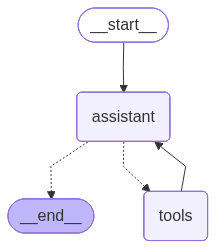

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

#Graph
builder = StateGraph(AgentState)

#Define nodes 
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

#Define nodes: these do the work
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition,)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show 
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
messages = [HumanMessage(content= "Divide 6790 by 5")]

messages = react_graph.invoke({"messages": messages, "input_file": None})

In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (m0yfzf5ph)
 Call ID: m0yfzf5ph
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

The result of dividing 6790 by 5 is 1358.0.


In [11]:
messages = [HumanMessage(content=" According the note provided by MR wayne in the provided images. What's the list of items I should buy for the ")]

messages = react_graph.invoke({"messages": messages, "input_file":"Batman_training_and_meals.png"})

In [12]:
for m in messages ['messages']:
    m.pretty_print()

================================ Human Message =================================

 According the note provided by MR wayne in the provided images. What's the list of items I should buy for the 
================================== Ai Message ==================================

I can't fulfill this request.
